<a href="https://colab.research.google.com/github/jorge-jrzz/UEA-ML_SRCNN/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super-Resolution with TensorFlow

La superresolución (SR) de una sola imagen es un problema clásico de visión por computadora que tiene como objetivo recuperar una imagen de alta resolución a partir de una imagen de menor resolución. Se han llevado a cabo numerosas investigaciones en este campo y con el avance del Deep Learning se han conseguido grandes resultados.

En este notebook, exploramos uno de los enfoques de Deep Learning para la super-resolución llamado [Super-Resolution Convolutional Neural Network (SRCNN)](https://arxiv.org/abs/1501.00092.). Esta técnica trabaja de principio a fin, extrayendo parches de la imagen de baja resolución y pasándolos por capas convolucionales para finalmente mapearlos en píxeles de salida de mayor resolución, como se muestra en el siguiente diagrama.

![SRCNN Architecture](https://debuggercafe.com/wp-content/uploads/2022/05/srcnn-architecture.png)

Como conjunto de datos de imágenes para entrenar el modelo, utilizaremos un conjunto de datos alojado en Kaggle llamado [Dog and Cat Detection](https://www.kaggle.com/andrewmvd/dog-and-cat-detection). Utilizaremos el modulo de kagglehub para descargar este el dataset; también puede descargar manualmente directamente desde el sitio web.

In [ ]:
#@title ## Instalación de dependencias
!wget https://raw.githubusercontent.com/jorge-jrzz/UEA-ML_SRCNN/refs/heads/main/install_datasets.py
!wget https://raw.githubusercontent.com/jorge-jrzz/UEA-ML_SRCNN/refs/heads/main/requirements.txt
%pip install -r requirements.txt --quiet

In [ ]:
from install_datasets import download_dataset

download_dataset("andrewmvd/dog-and-cat-detection")

Para guardar el checkpoints del modelo y otros artefactos, montaremos en Google Drive el contenedor de este colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pathlib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *

## Data

Necesitamos una función para cambiar el tamaño de las imágenes en base a un factor de escala, esto se utilizará más adelante en el proceso para generar imágenes de baja resolución a partir de una imagen dada.

In [6]:
def resize_image(image_array, factor):
    original_image = Image.fromarray(image_array)
    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)
    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resized = resized.astype(np.uint8)
    return resized

This function will use the resizing to generate low resolution images by downsizing then upsizing:

In [7]:
def downsize_upsize_image(image, scale):
    scaled = resize_image(image, 1.0 / scale)
    scaled = resize_image(scaled, scale / 1.0)
    return scaled

When we will extract patches, we will slide a window over the original image, and for the image to fit nicely we need to crop it with the following function

In [8]:
def tight_crop_image(image, scale):
    height, width = image.shape[:2]
    width -= int(width % scale)
    height -= int(height % scale)
    return image[:height, :width]

The following function is used to extract patches with a sliding window from an input image. The `INPUT_DIM` parameter is the height and width of the images as expected by the network

In [9]:
def crop_input(image, x, y):
    y_slice = slice(y, y + INPUT_DIM)
    x_slice = slice(x, x + INPUT_DIM)
    return image[y_slice, x_slice]

Similarly, we need to crop patches from the output images with `LABEL_SIZE` the height and width of the output of the network. We also need to pad the patches with `PAD` to make sure we are cropping the regions properly

In [10]:
def crop_output(image, x, y):
    y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
    x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
    return image[y_slice, x_slice]

Now let's read all image paths

In [11]:
file_patten = (pathlib.Path('/content') / 'images' / '*.png')
file_pattern = str(file_patten)
dataset_paths = [*glob(file_pattern)]

We don't need the entire dataset as this will take longer training, but will sample around 1000 images from it

In [12]:
SUBSET_SIZE = 1000
dataset_paths = np.random.choice(dataset_paths, SUBSET_SIZE)

Here is an example image from the dataset

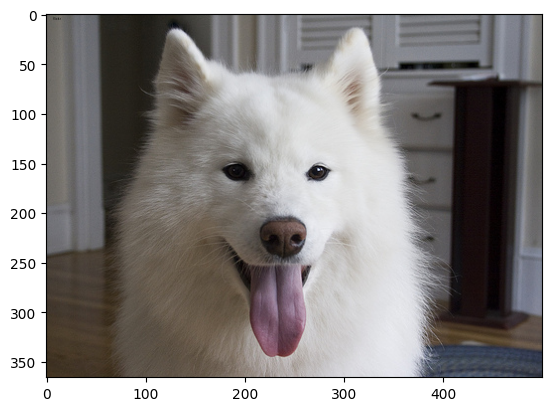

In [13]:
path = np.random.choice(dataset_paths)
img = plt.imread(path)
plt.imshow(img)

Here we define some parameters, like the scale for resiping, input and output patch sizes, the amount of padding that need to be added to output patches, and the stride which is the number of pixels we'll slide both in the horizontal and vertical axes to extract patches.

In [14]:
SCALE = 2.0
INPUT_DIM = 33
LABEL_SIZE = 21
PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)
STRIDE = 14

Now, lets build the dataset by reading the input images, generating a low resolution version, sliding a window on this low resolution image as well as the original image to generate patches for training.
We will save the patches to disk and later build a training data generator that will load them from disk in batches.

In [15]:
%%bash

mkdir -p data
mkdir -p training

In [16]:
for image_path in tqdm(dataset_paths):
    filename = pathlib.Path(image_path).stem
    image = load_img(image_path)
    image = img_to_array(image)
    image = image.astype(np.uint8)
    image = tight_crop_image(image, SCALE)
    scaled = downsize_upsize_image(image, SCALE)

    height, width = image.shape[:2]

    for y in range(0, height - INPUT_DIM + 1, STRIDE):
        for x in range(0, width - INPUT_DIM + 1, STRIDE):
            crop = crop_input(scaled, x, y)
            target = crop_output(image, x, y)
            np.save(f'data/{filename}_{x}_{y}_input.np', crop)
            np.save(f'data/{filename}_{x}_{y}_output.np', target)



100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


We cannot hold all the patches in memory hence we saved to disk in the previous step. Now we need a dataset loader that will load a patch and its label and feed them to the network during traning in batches. This is achieved with the `PatchesDataset` class (check this example to learn more about generators - [link](https://dzlab.github.io/dltips/en/keras/data-generator/)).

In [17]:
class PatchesDataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size, *args, **kwargs):
        self.batch_size = batch_size
        self.input = [*glob('data/*_input.np.npy')]
        self.output = [*glob('data/*_output.np.npy')]
        self.input.sort()
        self.output.sort()
        self.total_data = len(self.input)

    def __len__(self):
        # returns the number of batches
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        # returns one batch
        indices = self.random_indices()
        input = np.array([np.load(self.input[idx]) for idx in indices])
        output = np.array([np.load(self.output[idx]) for idx in indices])
        return input, output

    def random_indices(self):
        return np.random.choice(list(range(self.total_data)), self.batch_size, p=np.ones(self.total_data)/self.total_data)


Define a batch size based on how much memory available on your GPU and create an instance of the dataset generator.

In [18]:
BATCH_SIZE = 1024
train_ds = PatchesDataset(BATCH_SIZE)
len(train_ds)

633

You can see the shape of the training batches

In [19]:
input, output = train_ds[0]
input.shape, output.shape

((1024, 33, 33, 3), (1024, 21, 21, 3))

## Model

The architecture of the SRCNN model is very simple, it has only convolutional layers, one to downsize the input and extract image features and a later one to upside to generate the output image. The following helper function is used to create an instance of the model.

In [20]:
def create_model(height, width, depth):
    input = Input(shape=(height, width, depth))
    x = Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='he_normal')(input)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    output = Conv2D(filters=depth, kernel_size=(5, 5), kernel_initializer='he_normal')(x)
    return Model(input, output)

To train the network we will use `Adam` as optimizer with learning rate decay. Also, as the problem we try to train the network for is a regression problem (we want predict the high resolution pixels) we pick `MSE` as a loss function, this will make the model learn the filters that correctly map patches from low to high resolution.

In [21]:
EPOCHS = 12
optimizer = Adam(learning_rate=1e-3, decay=1e-3 / EPOCHS)
model = create_model(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss='mse', optimizer=optimizer)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


You can see how the model is small but astonishly it will be able to achieve great results once trained for enough time, we will train it for 12 epochs

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33, 33, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 25, 25, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 3)      │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

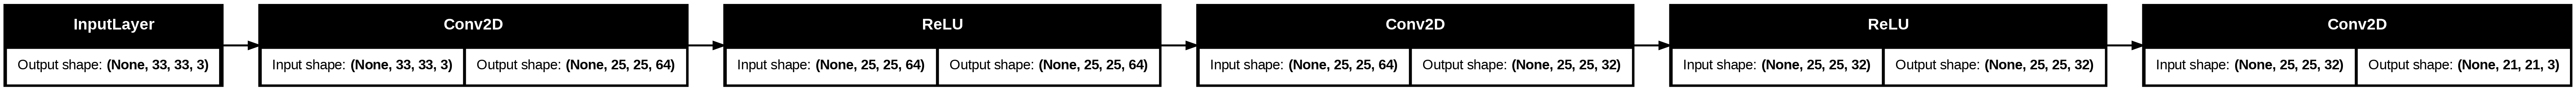

In [23]:
tf.keras.utils.plot_model(model, show_shapes = True, rankdir='LR')

Create a callback that saves the model's weights

In [25]:
checkpoint_path = "training/cp.weights.h5" # Changed the file extension to .weights.h5
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

Now finally, we can train the network

In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[cp_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
573/633 ━━━━━━━━━━━━━━━━━━━━ 58s 975ms/step - loss: 961.3384

make sure `super_resolution` folder exists in Google Drive

In [ ]:
%%bash

mkdir -p /content/drive/MyDrive/super_resolution
cp -r training/* /content/drive/MyDrive/super_resolution

save and load the model

In [ ]:
path = '/content/drive/MyDrive/super_resolution/model.h5'
model.save(path)
new_model = tf.keras.models.load_model(path)

## Evaluation

After train the model for enough time we can evaluate it. Let's pick a random image from the dataset (or you can use anyother image) and transform it into a low resolution image that we can pass to the SRCNN model.

In [ ]:
path = np.random.choice(dataset_paths)
image = load_img(path)
image = img_to_array(image)
image = image.astype(np.uint8)
image = tight_crop_image(image, SCALE)
scaled = downsize_upsize_image(image, SCALE)

We need a placeholder where we will put the output patches to create the final image

In [ ]:
output = np.zeros(scaled.shape)
height, width = output.shape[:2]

Now we extarct patches from the input image, pass them through the trained model to generate high resolution patch and then put this patch in the right position on the previous placeholder. After processing every patch from the input image we will have a final output image

In [ ]:
for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
    for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
        crop = crop_input(scaled, x, y)
        image_batch = np.expand_dims(crop, axis=0)
        prediction = model.predict(image_batch)
        new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
        prediction = prediction.reshape(new_shape)
        output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
        output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
        output[output_y_slice, output_x_slice] = prediction

Now we can display side by side the low resolution image as well as the resulting output image which is of higher resolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 299.5, 197.5, -0.5)

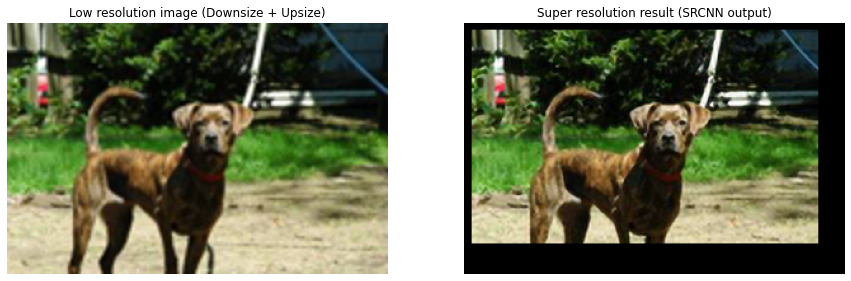

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(15, 8))
axis[0].imshow(np.array(scaled,np.int32))
axis[0].set_title('Low resolution image (Downsize + Upsize)')
axis[0].axis('off')

axis[1].imshow(np.array(output,np.int32))
axis[1].set_title('Super resolution result (SRCNN output)')
axis[1].axis('off')

Very impressive result considering the small model that we trained, as you can see it was able to considerably improve the resolution of the input image.